In [32]:

import pandas as pd
import numpy as np
import os
from pypfopt import EfficientFrontier, risk_models, expected_returns
import matplotlib.pyplot as plt

In [33]:
#  Loading historical returns
all_data_df = pd.read_csv("../data/final_features_with_targets.csv", parse_dates=['Date'], index_col='Date')
assets = ['EEM', 'Gold', 'FTSE100', 'S&P500', 'Nikkei225', 'UST10Y']
log_ret_cols = [f"{asset}_log_ret" for asset in assets]
historical_returns = all_data_df[log_ret_cols].dropna()
historical_returns.columns = assets

# Clean for NaN and Inf
historical_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
historical_returns.dropna(inplace=True)

# 2. Load model-predicted returns (from regression results)
results_dir = "regression_results"
all_predictions_df = pd.DataFrame()
for asset in assets:
    try:
        pred_path = os.path.join(results_dir, f"{asset}_regressor_predictions.csv")
        preds = pd.read_csv(pred_path)
        all_predictions_df[asset] = preds['predicted_return']
    except FileNotFoundError:
        all_predictions_df[asset] = 0  # Fallback if missing

# Clean model predictions
all_predictions_df.replace([np.inf, -np.inf], np.nan, inplace=True)
all_predictions_df.fillna(0, inplace=True)

# Align dates
test_dates = historical_returns.index[-len(all_predictions_df):]
all_predictions_df.index = test_dates



In [34]:
covariance_lookback = 60
portfolio_weights_over_time = []
test_period_dates = all_predictions_df.index
print("Starting robust rolling optimization...")

for current_date in test_period_dates:
    predicted = all_predictions_df.loc[current_date]

    try:
        end_loc = historical_returns.index.get_loc(current_date)
        start_loc = end_loc - covariance_lookback
        if start_loc < 0:
            continue

        rolling_data = historical_returns.iloc[start_loc:end_loc]
        # Robust covariance estimate (Ledoit-Wolf shrinkage)
        S = risk_models.risk_matrix(rolling_data, method='ledoit_wolf')
        if np.isinf(S).values.any() or S.isnull().values.any():
            raise ValueError()

    except Exception:
        # If any error, fallback to diagonal covariance (only individual variances)
        variances = rolling_data.var().values
        variances[~np.isfinite(variances)] = 1e-6
        S = np.diag(variances)
        S = pd.DataFrame(S, index=assets, columns=assets)

    try:
        ef = EfficientFrontier(predicted, S)
        ef.add_constraint(lambda w: np.sum(w) == 1)
        ef.add_constraint(lambda w: w >= 0)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        portfolio_weights_over_time.append(cleaned_weights)
    except Exception:
        fallback_weights = {asset: 1/len(assets) for asset in assets}
        portfolio_weights_over_time.append(fallback_weights)

weights_df = pd.DataFrame(portfolio_weights_over_time, index=test_period_dates[:len(portfolio_weights_over_time)])
print("Portfolio weights calculated.")
print(weights_df.head())


Starting robust rolling optimization...


/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/mingi/Quantitative

Portfolio weights calculated.
                 EEM      Gold   FTSE100    S&P500  Nikkei225    UST10Y
Date                                                                   
2022-02-10  0.166667  0.166667  0.166667  0.166667   0.166667  0.166667
2022-02-14  0.166667  0.166667  0.166667  0.166667   0.166667  0.166667
2022-02-15  0.166667  0.166667  0.166667  0.166667   0.166667  0.166667
2022-02-16  0.166667  0.166667  0.166667  0.166667   0.166667  0.166667
2022-02-17  0.166667  0.166667  0.166667  0.166667   0.166667  0.166667


/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/covariance/_shrunk_covariance.py:363: RuntimeWarning: overflow encountered in square
  X2 = X**2
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/covariance/_shrunk_covariance.py:363: RuntimeWarning: overflow encountered in square
  X2 = X**2
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/covariance/

In [35]:
# Ensure alignment for multiplying weights & returns
aligned_returns = historical_returns.reindex(index=weights_df.index, columns=weights_df.columns)

# AI portfolio: daily returns by summing weighted actual asset returns
ai_portfolio_returns = (weights_df * aligned_returns).sum(axis=1)

# DataFrame for results
performance_df = pd.DataFrame({'AI_Portfolio': ai_portfolio_returns})

# Equal Weight Benchmark
num_assets = len(weights_df.columns)
ew_array = np.array([1/num_assets] * num_assets)
ew_returns = (aligned_returns * ew_array).sum(axis=1)
performance_df['Equal_Weight'] = ew_returns


In [36]:
try:
    train_returns = historical_returns.loc[:weights_df.index[0]].iloc[:-1]
    mu_static = expected_returns.mean_historical_return(train_returns)
    S_static = risk_models.risk_matrix(train_returns, method='ledoit_wolf')
    ef_static = EfficientFrontier(mu_static, S_static)
    ef_static.max_sharpe()
    static_weights = ef_static.clean_weights()
    static_weights_array = np.array([static_weights.get(asset, 0) for asset in weights_df.columns])
    static_mvo_returns = (aligned_returns * static_weights_array).sum(axis=1)
    performance_df['Static_MVO'] = static_mvo_returns
except Exception as e:
    print("Static MVO benchmark failed:", e)


Static MVO benchmark failed: Input contains NaN.


/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/pypfopt/expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/_core/_methods.py:56: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepd

In [37]:

#unique_allocations = weights_df.drop_duplicates()
#print("Number of unique AI portfolio allocations:", len(unique_allocations))
#print(unique_allocations.head())

print(all_predictions_df.head(10))
print(all_predictions_df.describe())

def calc_metrics(returns, rf=0.0):
    n = 252
    ann_return = ((1 + returns).prod() ** (n/len(returns))) - 1
    ann_vol = returns.std() * np.sqrt(n)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(n) if returns.std() > 0 else 0
    cumret = (1 + returns).cumprod()
    maxdd = (cumret / cumret.cummax() - 1).min()
    return pd.Series({
        "Annualized Return": f"{ann_return:.2%}",
        "Annualized Volatility": f"{ann_vol:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Maximum Drawdown": f"{maxdd:.2%}"
    })

results = pd.DataFrame({col: calc_metrics(performance_df[col]) for col in performance_df.columns})
print(results)


                 EEM      Gold   FTSE100    S&P500  Nikkei225    UST10Y
Date                                                                   
2022-02-10  0.000528 -0.004961 -0.006362  0.003521   0.002528  0.003172
2022-02-14 -0.000329 -0.004972 -0.006149  0.003357   0.002521  0.003463
2022-02-15  0.001108 -0.005043 -0.006099  0.001842   0.002657  0.002828
2022-02-16  0.000788 -0.005234 -0.006445  0.001836   0.001854  0.007536
2022-02-17  0.000697 -0.005208 -0.006361  0.000896   0.001849  0.007278
2022-02-18  0.000354 -0.005108 -0.006374  0.000508   0.001194  0.007040
2022-02-22 -0.001228 -0.005040 -0.006319  0.000991   0.001463  0.001624
2022-02-24 -0.000697 -0.005231 -0.005732  0.001143   0.001789  0.001460
2022-02-25  0.001259 -0.005175 -0.005819  0.000528   0.001214  0.001299
2022-02-28  0.003392 -0.005289 -0.005740  0.000029   0.000447  0.005891
              EEM        Gold     FTSE100      S&P500   Nikkei225      UST10Y
count  670.000000  670.000000  670.000000  670.000000  670

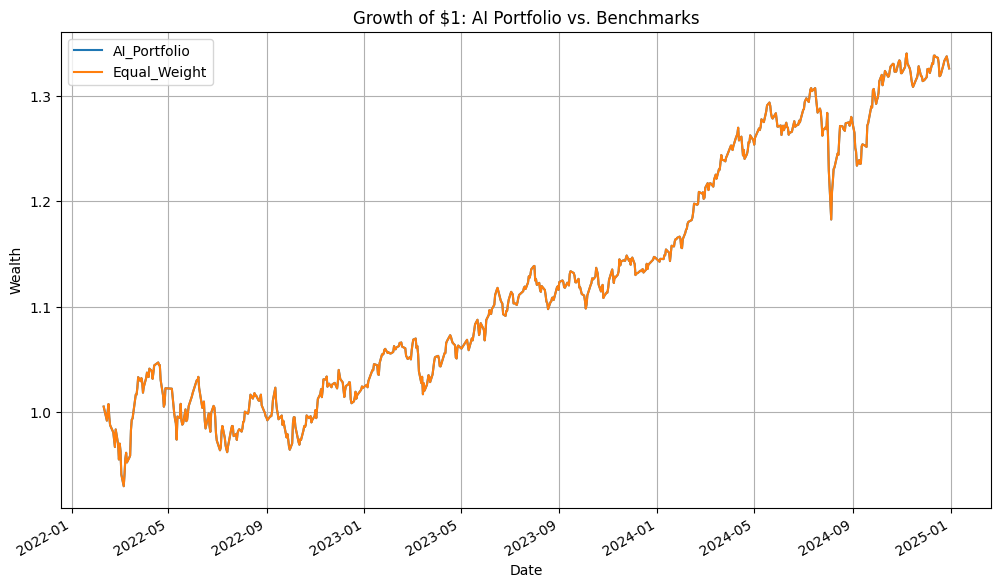

In [38]:
(1 + performance_df).cumprod().plot(figsize=(12, 7))
plt.title("Growth of $1: AI Portfolio vs. Benchmarks")
plt.grid(True)
plt.ylabel("Wealth")
plt.show()
